In [21]:
#new plotting code
#new samples (607078)

# Imports

In [29]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import scipy.interpolate as interp
import lalsimulation as lal
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model
import keras
import keras_metrics as km
import keras
import keras_metrics as km
from keras import metrics

In [30]:
gamma0 = np.loadtxt("eos_polytrope_gamma_0.dat.txt", dtype=float)
gamma1 = np.loadtxt("eos_polytrope_gamma_1.dat.txt", dtype=float)
gamma2 = np.loadtxt("eos_polytrope_gamma_2.dat.txt", dtype=float)
l1 = np.loadtxt('lambda_1.dat.txt', dtype=float)
l2 = np.loadtxt('lambda_2.dat.txt', dtype=float)
logp1_cgs = np.loadtxt("eos_polytrope_log_pressure_1.dat.txt", dtype=float)
logp2_cgs = np.loadtxt("eos_polytrope_log_pressure_2.dat.txt", dtype=float)
m1 = np.loadtxt("mass_1_source.dat.txt", dtype=float)
m2 = np.loadtxt("mass_2_source.dat.txt", dtype=float)

In [31]:
len(m2)

607078

In [32]:
logp1_s = logp1_cgs - 1
logp2_s = logp2_cgs - 1

# Functions

In [33]:
#formatting array & processing outputs

def format_output(data):
    gamma0 = data.pop('gamma0')
    gamma0 = np.array(gamma0)
    gamma1 = data.pop('gamma1')
    gamma1 = np.array(gamma1)
    gamma2 = data.pop('gamma2')
    gamma2 = np.array(gamma2)
    logp1_si = data.pop('logp1_si')
    logp1_si = np.array(logp1_si)
    logp2_si = data.pop('logp2_si')
    logp2_si = np.array(logp2_si)
    return gamma0, gamma1, gamma2, logp1_si, logp2_si



In [34]:
#normalize and save the new array, and the max

def minmax(inputarray):
    
    absinput = np.abs(inputarray)
    gmax = absinput.max()
    newarray = inputarray / gmax
                
    return newarray, gmax


In [35]:
#return inputs back to original values in order to plot EOS

def unnorm(predictionsarray, gam0max, gam1max, gam2max, logp1max, logp2max):
    
    for i in range (len(predictionsarray)):
        new_gamma0_array = predictionsarray[0] * gam0max
        new_gamma1_array = predictionsarray[1] * gam1max
        new_gamma2_array = predictionsarray[2] * gam2max
        new_logp1_array = predictionsarray[3] *  logp1max
        new_logp2_array = predictionsarray[4] *  logp2max
    
    new_array = np.concatenate((new_gamma0_array, new_gamma1_array, new_gamma2_array, new_logp1_array, new_logp2_array), axis=1)

    return new_array

# MLA

In [36]:
# not normalized

l1_dat = (l1)
l2_dat = (l2)
m1_dat = (m1)
m2_dat = (m2)

sd_gamma0 = (gamma0)
sd_gamma1 = (gamma1)
sd_gamma2 = (gamma2)
logp1_si  = (logp1_s)
logp2_si  = (logp2_s)

In [37]:
#normalizing inputs and outputs

l1_dat, l1max = minmax(l1)
l2_dat, l2max = minmax(l2)
m1_dat, m1max = minmax(m1)
m2_dat, m2max = minmax(m2)


sd_gamma0, gam0max = minmax(gamma0)
sd_gamma1, gam1max = minmax(gamma1)
sd_gamma2, gam2max = minmax(gamma2)
logp1_si, logp1max = minmax(logp1_s)
logp2_si, logp2max = minmax(logp2_s)


In [38]:
#create an empty array 8 x length(m1_dat]) for vals
array_size =  np.array([[0] * 9 ] * len(sd_gamma0))
array_size = array_size.astype('float64')
combined_array = np.zeros_like(array_size)
print(combined_array.dtype)
print(combined_array.shape)

float64
(607078, 9)


In [39]:
#reformat data files into this new array
for i in range(0,len(m1_dat)-1):
    combined_array[i][0] = m1_dat[i]
    combined_array[i][1] = m2_dat[i]
    combined_array[i][2] = l1_dat[i]
    combined_array[i][3] = l2_dat[i]
    combined_array[i][4] = sd_gamma0[i]
    combined_array[i][5] = sd_gamma1[i]
    combined_array[i][6] = sd_gamma2[i]
    combined_array[i][7] = logp1_si[i]
    combined_array[i][8] = logp2_si[i]
    

In [40]:
data = pd.DataFrame(combined_array)
data.columns = ['m1','m2', 'l1', 'l2','gamma0', 'gamma1', 'gamma2', 'logp1_si', 'logp2_si']
print(data)

              m1        m2            l1            l2    gamma0    gamma1  \
0       0.399037  0.231189  2.678011e-17  2.678011e-17  0.549962  0.832745   
1       0.157847  0.120106  2.355229e-14  2.355229e-14  0.719085  0.796390   
2       0.455261  0.399788  9.258248e-17  9.258248e-17  0.704070  0.990509   
3       0.136398  0.089042  2.675254e-14  2.675254e-14  0.583426  0.229972   
4       0.628436  0.605635  2.823348e-17  2.823348e-17  0.850527  0.664295   
...          ...       ...           ...           ...       ...       ...   
607073  0.237326  0.196011  4.547367e-16  4.547367e-16  0.299136  0.793760   
607074  0.506660  0.518602  1.749305e-16  1.749305e-16  0.982146  0.901946   
607075  0.251925  0.111924  4.985997e-15  4.985997e-15  0.964900  0.825891   
607076  0.683673  0.302376  1.688295e-17  1.688295e-17  0.874367  0.784845   
607077  0.000000  0.000000  0.000000e+00  0.000000e+00  0.000000  0.000000   

          gamma2  logp1_si  logp2_si  
0       0.276914  0.9546

In [41]:
#split data into train and test

data = data.sample(frac=1).reset_index(drop=True)

train, test = train_test_split(data, test_size=0.2)

print(train)

train_stats = train.describe()

#get gamma as the outputs and format them as np arrays.

train_stats.pop('gamma0')
train_stats.pop('gamma1')
train_stats.pop('gamma2')
train_stats.pop('logp1_si')
train_stats.pop('logp2_si')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)

              m1        m2            l1            l2    gamma0    gamma1  \
2934    0.490417  0.452713  1.238163e-16  1.238163e-16  0.828493  0.957529   
95507   0.382378  0.293060  6.566252e-16  6.566252e-16  0.928682  0.705890   
119000  0.580632  0.119303  5.384505e-17  5.384505e-17  0.728153  0.976958   
258997  0.600070  0.264713  1.997167e-17  1.997167e-17  0.690692  0.965395   
505468  0.109290  0.072225  8.032824e-14  8.032824e-14  0.430491  0.706479   
...          ...       ...           ...           ...       ...       ...   
600489  0.354769  0.240161  6.577961e-16  6.577961e-16  0.803047  0.881901   
524010  0.123312  0.102750  8.811278e-14  8.811278e-14  0.833084  0.885541   
243101  0.246625  0.136574  2.643606e-15  2.643606e-15  0.647664  0.732428   
584739  0.446721  0.230761  1.114107e-16  1.114107e-16  0.712275  0.343906   
403610  0.163727  0.135401  2.401904e-14  2.401904e-14  0.798064  0.642429   

          gamma2  logp1_si  logp2_si  
2934    0.405471  0.9462

In [42]:
norm_train_X = train
norm_test_X = test

In [43]:

input_layer = Input(shape=(len(train .columns),))

first_dense = Dense(units='128', activation='tanh')(input_layer)
second_dense = Dense(units='128', activation='tanh')(first_dense)
third_dense = Dense(units='128', activation='tanh')(second_dense)
fourth_dense = Dense(units='128', activation='tanh')(third_dense)
fifth_dense = Dense(units='128', activation='tanh')(fourth_dense)
sixth_dense = Dense(units='128', activation='tanh')(fifth_dense)
seventh_dense = Dense(units='128', activation='tanh')(sixth_dense)
eight_dense = Dense(units='128', activation='tanh')(seventh_dense)
ninth_dense = Dense(units='128', activation='tanh')(eight_dense)
    
tenth_dense = Dense(units='128', activation='tanh')(ninth_dense)
eleventh_dense = Dense(units='128', activation='tanh')(tenth_dense)
twelth_dense = Dense(units='128', activation='tanh')(eleventh_dense)
thirteenth_dense = Dense(units='128', activation='tanh')(twelth_dense)
fourteenth_dense = Dense(units='128', activation='tanh')(thirteenth_dense)
fifteenth_dense = Dense(units='128', activation='tanh')(fourteenth_dense)
sixteenth_dense = Dense(units='128', activation='tanh')(fifteenth_dense)
seventeenth_dense = Dense(units='128', activation='tanh')(sixteenth_dense)
eighteenth_dense = Dense(units='128', activation='tanh')(seventeenth_dense)
nineteenth_dense = Dense(units='128', activation='tanh')(eighteenth_dense)
    
twentieth_dense = Dense(units='128', activation='tanh')(nineteenth_dense)
tf_dense = Dense(units='128', activation='tanh')(twentieth_dense)
ts_dense = Dense(units='128', activation='tanh')(tf_dense)
tt_dense = Dense(units='128', activation='tanh')(ts_dense)
tfo_dense = Dense(units='128', activation='tanh')(tt_dense)
tfi_dense = Dense(units='128', activation='tanh')(tfo_dense)
ts_dense = Dense(units='128', activation='tanh')(tfi_dense)
tse_dense = Dense(units='128', activation='tanh')(ts_dense)
te_dense = Dense(units='128', activation='tanh')(tse_dense)
tn_dense = Dense(units='128', activation='tanh')(te_dense)


gamma0_output = Dense(units='1', activation='tanh', name='gamma0_output')(tn_dense)
thf_dense = Dense(units='64', activation='tanh')(tn_dense)

ths_dense = Dense(units='128', activation='tanh')(thf_dense)
tht_dense = Dense(units='128', activation='tanh')(ths_dense)
thfo_dense = Dense(units='128', activation='tanh')(tht_dense)
thfi_dense = Dense(units='128', activation='tanh')(thfo_dense)
ths_dense = Dense(units='128', activation='tanh')(thfi_dense)
thse_dense = Dense(units='128', activation='tanh')(ths_dense)
the_dense = Dense(units='128', activation='tanh')(thse_dense)
thn_dense = Dense(units='128', activation='tanh')(the_dense)

gamma1_output = Dense(units='1', activation='tanh', name='gamma1_output')(thn_dense)
fo_dense = Dense(units='32',activation='tanh')(thn_dense)

fof_dense = Dense(units='128', activation='tanh')(fo_dense)
fos_dense = Dense(units='128', activation='tanh')(fof_dense)
fot_dense = Dense(units='128', activation='tanh')(fos_dense)
fofo_dense = Dense(units='128', activation='tanh')(fot_dense)
fofi_dense = Dense(units='128', activation='tanh')(fofo_dense)

gamma2_output = Dense(units='1', activation='tanh', name='gamma2_output')(fofi_dense)
fos_dense = Dense(units='16',activation='tanh')(fofi_dense)

fose_dense = Dense(units='128', activation='tanh')(fos_dense)
foe_dense = Dense(units='128', activation='tanh')(fose_dense)
fon_dense = Dense(units='128', activation='tanh')(foe_dense)
fif_dense = Dense(units='128', activation='tanh')(fon_dense)

logp1_si_output = Dense(units='1', activation='tanh', name='logp1_si_output')(fon_dense)

fiff_dense = Dense(units='128', activation='tanh')(fon_dense)
fifs_dense = Dense(units='128', activation='tanh')(fiff_dense)
fift_dense = Dense(units='128', activation='tanh')(fifs_dense)
fiff_dense = Dense(units='128', activation='tanh')(fift_dense)
fiffi_dense = Dense(units='128', activation='tanh')(fiff_dense)
fifs_dense = Dense(units='128', activation='tanh')(fiffi_dense)

logp2_si_output = Dense(units='1', activation='tanh', name='logp2_si_output')(fifs_dense)


model = Model(inputs=input_layer, outputs=[gamma0_output, gamma1_output, gamma2_output, logp1_si_output, logp2_si_output])

print(model.summary())

2023-07-28 08:53:37.103103: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 4)]          0           []                               
                                                                                                  
 dense (Dense)                  (None, 128)          640         ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 128)          16512       ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 128)          16512       ['dense_1[0][0]']                
                                                                                              

 dense_39 (Dense)               (None, 128)          4224        ['dense_38[0][0]']               
                                                                                                  
 dense_40 (Dense)               (None, 128)          16512       ['dense_39[0][0]']               
                                                                                                  
 dense_41 (Dense)               (None, 128)          16512       ['dense_40[0][0]']               
                                                                                                  
 dense_42 (Dense)               (None, 128)          16512       ['dense_41[0][0]']               
                                                                                                  
 dense_43 (Dense)               (None, 128)          16512       ['dense_42[0][0]']               
                                                                                                  
 dense_44 

In [44]:
#plot_model(model, to_file='DynamicPolytropeMLA.png', show_shapes=True, show_layer_names=True)

In [45]:
#specify the optimizer as stochastic gradient descent and will mention the learning rate as 0.001
#compile the model with loss functions for both outputs
from keras import metrics

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss={'gamma0_output': 'mse', 'gamma1_output': 'mse', 'gamma2_output': 'mse', 'logp1_si_output': 'mse', 'logp2_si_output': 'mse'},
              metrics={
                       'gamma0_output': tf.keras.metrics.MeanSquaredError() ,
                       'gamma1_output': tf.keras.metrics.MeanSquaredError(),
                       'gamma2_output': tf.keras.metrics.MeanSquaredError() ,
                       'logp1_si_output': tf.keras.metrics.MeanSquaredError(),
                       'logp2_si_output': tf.keras.metrics.MeanSquaredError()
                      })

endmetric = "mean_squared_error"

In [46]:
#train the model for a number of epochs

numepochs = 200
    
history = model.fit(norm_train_X.to_numpy(), train_Y,
                    epochs=numepochs, batch_size=10, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001,patience=50,mode='auto')])


Epoch 1/200
36324/38853 [===========================>..] - ETA: 43s - loss: 0.0882 - gamma0_output_loss: 0.0319 - gamma1_output_loss: 0.0464 - gamma2_output_loss: 0.0085 - logp1_si_output_loss: 7.6625e-04 - logp2_si_output_loss: 5.0410e-04 - gamma0_output_mean_squared_error: 0.0319 - gamma1_output_mean_squared_error: 0.0464 - gamma2_output_mean_squared_error: 0.0085 - logp1_si_output_mean_squared_error: 7.6625e-04 - logp2_si_output_mean_squared_error: 5.0410e-04

KeyboardInterrupt: 

In [76]:
loss, gamma0_loss, gamma0_accuracy, gamma1_loss, gamma1_accuracy, gamma2_loss, gamma2_accuracy, logp1_si_loss, logp1_si_accuracy, logp2_si_loss, logp2_si_accuracy = model.evaluate(x=norm_test_X.to_numpy(), y=test_Y)


32/32 [==============================] - 1s 6ms/step - loss: 0.0965 - gamma0_output_loss: 0.0324 - gamma1_output_loss: 0.0472 - gamma2_output_loss: 0.0156 - logp1_si_output_loss: 7.4538e-04 - logp2_si_output_loss: 4.5792e-04 - gamma0_output_mean_squared_error: 0.0324 - gamma1_output_mean_squared_error: 0.0472 - gamma2_output_mean_squared_error: 0.0156 - logp1_si_output_mean_squared_error: 7.4538e-04 - logp2_si_output_mean_squared_error: 4.5792e-04


In [77]:
new_predictions = model.predict(norm_train_X.to_numpy())
predictions = unnorm(new_predictions, gam0max, gam1max, gam2max, logp1max, logp2max)

125/125 [==============================] - 1s 5ms/step


In [78]:
len(predictions)

4000

# Plot one EOS

In [179]:
fgam0 = float(predictions[0][0])
fgam1 = float(predictions[0][1])
fgam2 = float(predictions[0][2])
flogp1 = float(predictions[0][3])
flogp2 = float(predictions[0][4])

In [180]:
oneEOS = lal.SimNeutronStarEOS3PieceDynamicPolytrope(fgam0, flogp1, fgam1, flogp2, fgam2)

In [187]:
act_hmin = 0.01
act_hmax = lal.SimNeutronStarEOSMaxPseudoEnthalpy(oneEOS)

act_loghmin = np.log10(act_hmin)
act_loghmax = np.log10(act_hmax)

act_h_array = np.linspace(act_loghmin,act_loghmax,1000)

act_density = []
act_pressure = []

for h in act_h_array:
    act_density.append(lal.SimNeutronStarEOSRestMassDensityOfPseudoEnthalpy(10**h,oneEOS))
    act_pressure.append(lal.SimNeutronStarEOSPressureOfPseudoEnthalpy(10**h,oneEOS))
    
    
act_density = np.array(act_density)
act_pressure = np.array(act_pressure)

#cgs units
act_density_cgs = act_density * 1e-3
act_pressure_cgs = act_pressure * 10

act_logdensity = np.log10(act_density_cgs)
act_logpressure = np.log10(act_pressure_cgs)

Text(0, 0.5, 'pressure')

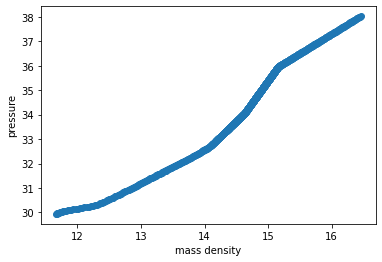

In [188]:
plt.plot(act_logdensity,act_logpressure,marker = 'o')
plt.xlabel("mass density")
plt.ylabel("pressure")
#plt.xlim([14,15.4])
#plt.ylim([32,37])

# EOS


In [100]:
#length = len(predictions)

length = 100

Progress : 0 / 100, 0.00%
Progress : 10 / 100, 10.00%
Progress : 20 / 100, 20.00%
Progress : 30 / 100, 30.00%
Progress : 40 / 100, 40.00%
Progress : 50 / 100, 50.00%
Progress : 60 / 100, 60.00%
Progress : 70 / 100, 70.00%
Progress : 80 / 100, 80.00%
Progress : 90 / 100, 90.00%


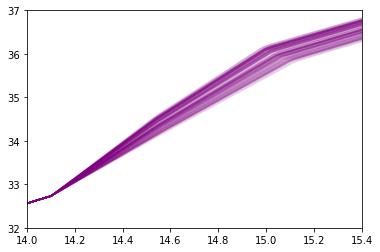

In [101]:
hlow_0 = 0.022460530117115313
hlow_1 = 0.024210313916473953
hlow = np.linspace(hlow_0,hlow_1,10,endpoint=False)
for i in range(length):

    g0 = float(predictions[i][0])
    g1 = float(predictions[i][1])
    g2 = float(predictions[i][2])
    p1 = float(predictions[i][3])
    p2 = float(predictions[i][4])
    
    if i%500==0:
        print('Progress : %d / %d, %0.2f%%'%(i,length,float(i/length*100)))
    pdat = []
    rdat = []
    #eos = lal.SimNeutronStarEOS3PieceDynamicPolytrope(g0[i],p1[i]-1,g1[i],p2[i]-1,g2[i])
    eos = lal.SimNeutronStarEOS3PieceDynamicPolytrope(g0,p1,g1,p2,g2)
    hmax = lal.SimNeutronStarEOSMaxPseudoEnthalpy(eos)
    hhigh = 10**np.linspace(np.log10(hlow_1),np.log10(hmax-.0001),100)
    hdat = np.concatenate([hlow,hhigh])
    for h in hdat:
        pdat.append(lal.SimNeutronStarEOSPressureOfPseudoEnthalpy(h,eos)*10)
        rdat.append(lal.SimNeutronStarEOSRestMassDensityOfPseudoEnthalpy(h,eos)*.001)
    #plt.plot(np.log10(rdat),np.log10(pdat),'o',alpha=0.15)
    plt.plot(np.log10(rdat),np.log10(pdat),color='purple',alpha=0.15)
plt.xlim([14,15.4])
plt.ylim([32,37])
plt.show()

# Actual Values EOS

In [27]:
gamma0 = np.loadtxt("eos_polytrope_gamma_0.dat.txt", dtype=float)
gamma1 = np.loadtxt("eos_polytrope_gamma_1.dat.txt", dtype=float)
gamma2 = np.loadtxt("eos_polytrope_gamma_2.dat.txt", dtype=float)
l1 = np.loadtxt('lambda_1.dat.txt', dtype=float)
l2 = np.loadtxt('lambda_2.dat.txt', dtype=float)
logp1_cgs = np.loadtxt("eos_polytrope_log_pressure_1.dat.txt", dtype=float)
logp2_cgs = np.loadtxt("eos_polytrope_log_pressure_2.dat.txt", dtype=float)
m1 = np.loadtxt("mass_1_source.dat.txt", dtype=float)
m2 = np.loadtxt("mass_2_source.dat.txt", dtype=float)

logp1_s = logp1_cgs - 1
logp2_s = logp2_cgs - 1

#length = len(gamma0)
length = 500

Progress : 0 / 500, 0.00%
Progress : 10 / 500, 2.00%
Progress : 20 / 500, 4.00%
Progress : 30 / 500, 6.00%
Progress : 40 / 500, 8.00%
Progress : 50 / 500, 10.00%
Progress : 60 / 500, 12.00%
Progress : 70 / 500, 14.00%
Progress : 80 / 500, 16.00%
Progress : 90 / 500, 18.00%
Progress : 100 / 500, 20.00%
Progress : 110 / 500, 22.00%
Progress : 120 / 500, 24.00%
Progress : 130 / 500, 26.00%
Progress : 140 / 500, 28.00%
Progress : 150 / 500, 30.00%
Progress : 160 / 500, 32.00%
Progress : 170 / 500, 34.00%
Progress : 180 / 500, 36.00%
Progress : 190 / 500, 38.00%
Progress : 200 / 500, 40.00%
Progress : 210 / 500, 42.00%
Progress : 220 / 500, 44.00%
Progress : 230 / 500, 46.00%
Progress : 240 / 500, 48.00%
Progress : 250 / 500, 50.00%
Progress : 260 / 500, 52.00%
Progress : 270 / 500, 54.00%
Progress : 280 / 500, 56.00%
Progress : 290 / 500, 58.00%
Progress : 300 / 500, 60.00%
Progress : 310 / 500, 62.00%
Progress : 320 / 500, 64.00%
Progress : 330 / 500, 66.00%
Progress : 340 / 500, 68.00%
P

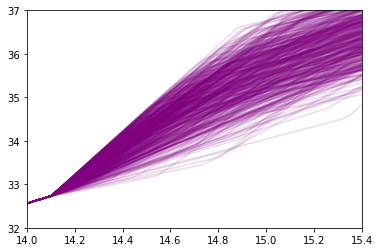

In [28]:
hlow_0 = 0.022460530117115313
hlow_1 = 0.024210313916473953
hlow = np.linspace(hlow_0,hlow_1,10,endpoint=False)
for i in range(length):

    g0 = float(gamma0[i])
    g1 = float(gamma1[i])
    g2 = float(gamma2[i])
    p1 = float(logp1_s[i])
    p2 = float(logp2_s[i])
    
    if i%10==0:
        print('Progress : %d / %d, %0.2f%%'%(i,length,float(i/length*100)))
    pdat = []
    rdat = []
    #eos = lal.SimNeutronStarEOS3PieceDynamicPolytrope(g0[i],p1[i]-1,g1[i],p2[i]-1,g2[i])
    eos = lal.SimNeutronStarEOS3PieceDynamicPolytrope(g0,p1,g1,p2,g2)
    hmax = lal.SimNeutronStarEOSMaxPseudoEnthalpy(eos)
    hhigh = 10**np.linspace(np.log10(hlow_1),np.log10(hmax-.0001),100)
    hdat = np.concatenate([hlow,hhigh])
    for h in hdat:
        pdat.append(lal.SimNeutronStarEOSPressureOfPseudoEnthalpy(h,eos)*10)
        rdat.append(lal.SimNeutronStarEOSRestMassDensityOfPseudoEnthalpy(h,eos)*.001)
    #plt.plot(np.log10(rdat),np.log10(pdat),'o',alpha=0.15)
    plt.plot(np.log10(rdat),np.log10(pdat),color='purple',alpha=0.15)
plt.xlim([14,15.4])
plt.ylim([32,37])
plt.show()

# Loss

In [185]:
history.history.keys() 

dict_keys(['loss', 'gamma0_output_loss', 'gamma1_output_loss', 'gamma2_output_loss', 'logp1_si_output_loss', 'logp2_si_output_loss', 'gamma0_output_mean_squared_error', 'gamma1_output_mean_squared_error', 'gamma2_output_mean_squared_error', 'logp1_si_output_mean_squared_error', 'logp2_si_output_mean_squared_error', 'val_loss', 'val_gamma0_output_loss', 'val_gamma1_output_loss', 'val_gamma2_output_loss', 'val_logp1_si_output_loss', 'val_logp2_si_output_loss', 'val_gamma0_output_mean_squared_error', 'val_gamma1_output_mean_squared_error', 'val_gamma2_output_mean_squared_error', 'val_logp1_si_output_mean_squared_error', 'val_logp2_si_output_mean_squared_error'])

ValueError: x and y must have same first dimension, but have shapes (63,) and (78,)

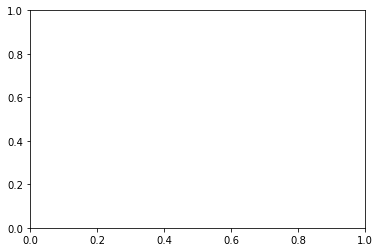

In [186]:
#loss for gamma0 values
loss_train = history.history['gamma0_output_loss']
loss_val = history.history['val_gamma0_output_loss']
epochs = range(0,63)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss for gamma0')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#loss for gamma1 values
loss_train = history.history['gamma1_output_loss']
loss_val = history.history['val_gamma1_output_loss']
epochs = range(0,63)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss for gamma1')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#loss for gamma2 values
loss_train = history.history['gamma2_output_loss']
loss_val = history.history['val_gamma2_output_loss']
epochs = range(0,63)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss for gamma2')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#loss for logp1_si values
loss_train = history.history['logp1_si_output_loss']
loss_val = history.history['val_logp1_si_output_loss']
epochs = range(0,63)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss for logp1_si')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


#loss for logp2_si values
loss_train = history.history['logp2_si_output_loss']
loss_val = history.history['val_logp2_si_output_loss']
epochs = range(0,63)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss for logp2_si')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()